# Predicting Taxi Trip Durations using KNN and Linear Regression

This notebook was inspired by the [Kaggle competition](https://kaggle.com/c/nyc-taxi-trip-duration). I accessed the March 2018 Yellow Cab trip data from the [New York Taxi and Limousine Corporation Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page) site for my analysis. 

The goal of this notebook is to explore concepts in KNN and linear regression using this dataset and assess the power of these models on predicting trip duration from location, time, and other variables. The motivation to do this is to apply theoretical concepts from data science to a real-world example in order to better understand these core concepts. 

## EDA and Feature Engineering

The first step is to examine the data (exploratory data analysis) and transform/engineer some of the features as needed in order to make the models work. Let's examine the data set:

In [1]:
# load in libraries for EDA, feature engineering

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load dataset into pandas dataframe
taxi_trips = pd.read_csv('yellow_tripdata_2018-03.csv')
taxi_trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-03-01 00:01:34,2018-03-01 00:01:43,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
1,1,2018-03-01 00:14:34,2018-03-01 00:28:13,1,3.3,1,N,151,244,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15
2,1,2018-03-01 00:51:25,2018-03-01 00:59:54,1,2.7,1,N,238,152,2,10.0,0.5,0.5,0.00,0.0,0.3,11.30
3,1,2018-03-01 00:00:01,2018-03-01 00:00:17,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80
4,1,2018-03-01 00:55:10,2018-03-01 00:56:36,1,3.7,1,N,145,145,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30


In [3]:
#how many records/features do we have?
taxi_trips.shape

(9430376, 17)

We have more than 9 million trips in March alone! We also have 17 feature columns (predictors). We can get information on what each of these features represents from the [TLC Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf). Some of the fields are:

* **VendorID** - what provider gave the record
* **Pickup/Dropoff datetime** - time of pickup and dropoff
* **Passenger count** - driver reported number of passengers
* **Trip distance** - elapsed trip distance (miles) as reported by taximeter
* **PU/DO LocationID** - taxi location zone of pickup (PU) and dropoff (DO)
* **RatecodeID** - the type of rate used

We should check our records for missingness and inconsistent values so that we can clean our dataset. We may also consider randomly dropping a fraction of the observations, since in this toy example, we may not want to mess around with all 9+ million records (for efficiency and speed of modeling). 

In [4]:
#check for missingness
taxi_trips.isnull().sum() #isnull generates a boolean and sum sums up the number of "True" instances

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [5]:
#look at data types
taxi_trips.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

We don't have any NaNs in our dataset which is nice. An examination of the data types shows that everything seems to be above board - fares are floats, IDs are ints, flags are text objects. The only issue is our datetime columns are objects (Pandas strings) and not actual datetime objects. We can correct that by switching the column type. 

In [6]:
#cast datetime columns into datetime format
#try to infer format of strings to speed up process
taxi_trips['tpep_pickup_datetime'] = pd.to_datetime(taxi_trips['tpep_pickup_datetime'], infer_datetime_format=True)
taxi_trips['tpep_dropoff_datetime'] = pd.to_datetime(taxi_trips['tpep_dropoff_datetime'], infer_datetime_format=True)
taxi_trips['tpep_pickup_datetime'].head()

0   2018-03-01 00:01:34
1   2018-03-01 00:14:34
2   2018-03-01 00:51:25
3   2018-03-01 00:00:01
4   2018-03-01 00:55:10
Name: tpep_pickup_datetime, dtype: datetime64[ns]

Now might a time to try some feature engineering - we don't actually have a column for trip duration (what we want to predict), but now that we have two columns with datetime format, we can easily make a new column with that data from them. 

In [7]:
taxi_trips['tpep_dropoff_datetime'][101] - taxi_trips['tpep_pickup_datetime'][101]
#taking the difference between two datetimes produces a timedelta (absolute difference in time)
#in this case 13 minutes and 29 seconds

Timedelta('0 days 00:13:29')

In [8]:
#create new timedelta column trip_duration

taxi_trips['trip_duration'] = taxi_trips['tpep_dropoff_datetime'] - taxi_trips['tpep_pickup_datetime']
taxi_trips['trip_duration'].head()

0   00:00:09
1   00:13:39
2   00:08:29
3   00:00:16
4   00:01:26
Name: trip_duration, dtype: timedelta64[ns]

We should look at some summary statistics of our dataset to make sure that all of the values for the numeric columns make sense

In [9]:
taxi_trips.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
count,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9.430376e+06,9430376
mean,1.567604e+00,1.601390e+00,2.864808e+00,1.042197e+00,1.629755e+02,1.611061e+02,1.312569e+00,1.265681e+01,3.343034e-01,4.973344e-01,1.847916e+00,3.253465e-01,3.000036e-01,1.596526e+01,0 days 00:16:34.163174
std,4.954086e-01,1.247606e+00,3.722331e+00,4.704546e-01,6.664959e+01,7.051072e+01,4.840774e-01,9.631818e+01,4.645647e-01,7.003697e-02,2.565877e+00,1.663388e+00,1.302640e+00,9.668569e+01,0 days 01:03:20.213158
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.740000e+02,-6.000000e+01,-5.000000e-01,-8.000000e+01,-3.800000e+01,-3.000000e-01,-3.748000e+02,-5 days +22:48:32
25%,1.000000e+00,1.000000e+00,9.400000e-01,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00,0 days 00:06:19
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.162000e+01,0 days 00:10:37
75%,2.000000e+00,2.000000e+00,2.940000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.400000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.716000e+01,0 days 00:17:30
max,2.000000e+00,9.000000e+00,3.028000e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.147484e+05,6.666000e+01,1.500000e+02,4.960000e+02,9.116100e+02,4.000300e+03,2.147502e+05,4 days 21:21:34


We definitely have some weird values here! A trip duration of -5 days or 4 days? Trip distances of 300 miles or 0 miles? We will need to clean up our data. We should examine those records and drop them if need be. 

In [10]:
#when is pickup time after dropoff time?
taxi_trips.loc[taxi_trips['trip_duration'] < pd.to_timedelta(0)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
1720422,1,2018-03-06 15:15:05,2018-03-05 16:05:01,2,9.9,1,N,70,48,1,40.5,0.0,0.5,9.4,5.76,0.3,56.46,-1 days +00:49:56
6264272,1,2018-03-21 08:20:35,2018-03-21 07:40:23,1,1.5,1,N,239,230,1,8.0,0.0,0.5,1.2,0.00,0.3,10.00,-1 days +23:19:48
7201330,1,2018-03-24 15:15:17,2018-03-20 14:03:49,1,1.2,1,N,74,75,2,8.0,1.0,0.5,0.0,0.00,0.3,9.80,-5 days +22:48:32


In [11]:
#these are likely errors in data recording (only 3 instances) - we can just drop them from our dataset
neg_dur_idx = taxi_trips.loc[taxi_trips['trip_duration'] < pd.to_timedelta(0)].index
taxi_trips.drop(neg_dur_idx, inplace=True) #dropping in place to avoid making copies of the v. large dataset

In [12]:
#can check if these rows are gone
taxi_trips.loc[taxi_trips['trip_duration'] < pd.to_timedelta(0)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration


In [13]:
#there should be no negative fare values 
taxi_trips.loc[taxi_trips['total_amount'] < 0].describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
count,5276.0,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276.000000,5276
mean,2.0,1.937832,0.292798,1.223844,163.998484,157.799280,3.282221,-8.702699,-0.360785,-0.487111,-0.061054,-0.039932,-0.299943,-9.955220,0 days 00:07:44.357657
std,0.0,1.521138,0.305260,0.803386,70.898638,68.921232,0.450544,19.630188,0.570191,0.079242,1.624954,0.729766,0.004130,19.868592,0 days 01:20:56.265928
min,2.0,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,-374.000000,-4.500000,-0.500000,-80.000000,-38.000000,-0.300000,-374.800000,0 days 00:00:00
25%,2.0,1.000000,0.020000,1.000000,113.000000,107.000000,3.000000,-5.000000,-0.500000,-0.500000,0.000000,0.000000,-0.300000,-6.300000,0 days 00:00:34
50%,2.0,1.000000,0.170000,1.000000,162.000000,161.000000,3.000000,-3.500000,0.000000,-0.500000,0.000000,0.000000,-0.300000,-4.800000,0 days 00:01:46
75%,2.0,2.000000,0.540000,1.000000,234.000000,230.000000,4.000000,-2.500000,0.000000,-0.500000,0.000000,0.000000,-0.300000,-3.800000,0 days 00:03:52
max,2.0,7.000000,1.010000,6.000000,265.000000,265.000000,4.000000,-0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.310000,0 days 23:59:53


There seems to a bias in payment types ("mean" is 3-4) for these transactions - payment types 3 and 4 are no charge and dispute transactions. We can check out the distribution of payment types for all transactions vs. "negative fare" transactions to get a sense of the breakdown of payment types

Text(0.5, 1.0, 'Neg Fare Trips')

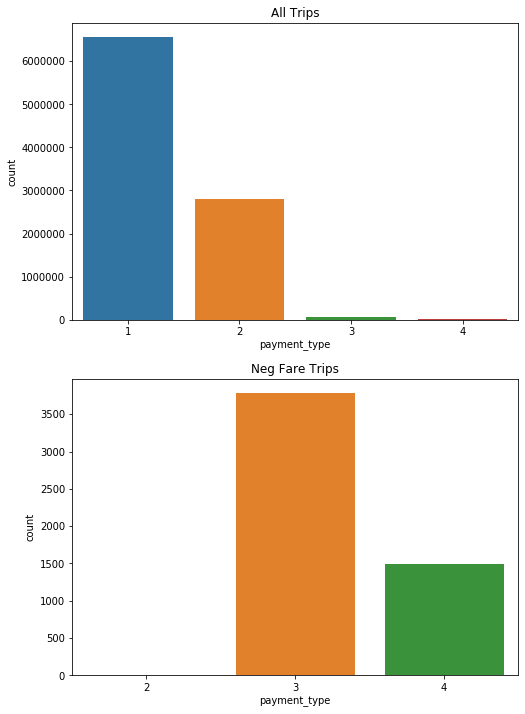

In [14]:
neg_fare_trips = taxi_trips.loc[taxi_trips['total_amount'] < 0]

fig, ax = plt.subplots(2,1, figsize = (8,12))
sns.countplot(x = 'payment_type', data = taxi_trips, ax = ax[0])
sns.countplot(x = "payment_type", data = neg_fare_trips, ax = ax[1])

ax[0].set_title('All Trips')
ax[1].set_title('Neg Fare Trips')

Yep, as we expected the 'no charge' and 'disputed' transactions (payment_type 3 and 4) are overrepresented in the negative fare records. We should drop these records as they make up a v. small % of our total data and it will make our fare features much cleaner. 

In [15]:
neg_fare_idx = taxi_trips.loc[taxi_trips['total_amount'] < 0].index
taxi_trips.drop(neg_fare_idx, inplace=True)

We should now check our distribution of trip durations - we want to visually examine for outliers, such as trips that are too long or too short. 